<a href="https://colab.research.google.com/github/dhguslee/leedo/blob/main/Machine%20Learning%20Code/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RNN (Recurrent Neural Network)**

---

## **첫 번째 프로젝트 : 다층 RNN으로 IMDb 영화 리뷰의 감성 분석 수행**

#### 데이터 압축 해제 및 읽기

In [ ]:
# ### 저장하고 압축 해제한 파일 읽기

# import os
# import tarfile

# if not os.path.isdir('/content/drive/MyDrive/data'):

#     with tarfile.open('aclImdb_v1.tar.gz', 'r:gz') as tar:
#         tar.extractall()


# ### 위 개개의 텍스트 문서를 하나의 CSV파일로 만들기
# ! pip install pyprind
# import pyprind      # pip install pyprind : 진행과정 확인과 예상 시간 추측에 사용
# import pandas as pd
# import os

# # `basepath`를 압축 해제된 영화 리뷰 데이터셋이 있는 디렉토리로 바꾸세요

# basepath = '/content/drive/MyDrive/data'

# labels = {'pos': 1, 'neg': 0}
# pbar = pyprind.ProgBar(50000)
# df = pd.DataFrame()
# for s in ('test', 'train'):
#     for l in ('pos', 'neg'):
#         path = os.path.join(basepath, s, l)
#         for file in sorted(os.listdir(path)):
#             with open(os.path.join(path, file), 
#                       'r', encoding='utf-8') as infile:
#                 txt = infile.read()
#             df = df.append([[txt, labels[l]]], 
#                            ignore_index=True)
#             pbar.update()
# df.columns = ['review', 'sentiment']


# ### 데이터를 섞어 CSV로 저장.
# import numpy as np

# np.random.seed(0)
# df = df.reindex(np.random.permutation(df.index))
# df.to_csv('movie_data.csv', index=False, encoding='utf-8')

### **1. Data Preparation**

#### **1) Data 불러오기**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# 4/1AY0e-g4lq-s1-1g2SqaSIMLHVh1mb2FXUnXVLsi7WgDstUsrn1ES08FaCvY

In [ ]:
# ! pip install pyprind
import numpy as np
import pandas as pd
from string import punctuation
import re
import pyprind

df = pd.read_csv("/content/drive/MyDrive/data/movie_data.csv", encoding = "utf-8")

# Columns : "review", "sentiment"
             # review : 영화 리뷰 텍스트 (= 단어의 시퀀스)
             # sentiment : 0 or 1
df.head(), df["review"][0], df.shape

#### **2) 텍스트를 정수 값으로 인코딩**

In [ ]:
# ### Counter 클래스
# from collections import Counter

# c1 = Counter()
# c2 = Counter()
# c3 = Counter()

# c1.update("abc")
# c2.update(["a", "b"])
# c3.update({"a" : 2, "b" : 2, "c" : 4})


# print("c1 : ", c1, "c2 : ", c2, "c3 : ", c3)

# print("c1에서 'a'개수 : ", c1["a"], "\n"
#       "c3에서 가장 높은 카운트값 2개 :", c3.most_common(2))

In [ ]:
### 단어를 나누고 등장 횟수를 카운트

from collections import Counter

# 소요시간 표현

pbar = pyprind.ProgBar(len(df["review"]), 
                       title = "단어의 등자 횟수를 카운트합니다.")

counts = Counter()

for i, review in enumerate(df["review"]) :
  

  text = "".join([c if c not in punctuation else " "+c+" " for c in review]).lower()      # 한 문장을 한 글자씩 떼어가며 적용
                                           # 각 글자가 구두점이면 양쪽에 공백 추가
                                                                    # 구두점이 아니면 그대로(공백도 그대로 생존)
                                                                    # 각 글자를 공백없이 결합하여 다시 문장으로 복귀
  df.loc[i, "review"] = text      # review를 text에서 만든 문장으로 수정 
  pbar.update()
  counts.update(text.split())     # 공백을 기준으로 문자를 나누어 각 개수 세기
                                  # 즉, 각 단어와 구두점 개수 출력


### 고유한 각 단어를 점수로 매핑하는 딕셔너리 생성

word_counts = sorted(counts, key = counts.get, reverse = True)  # counts 중 가장 많이 나온 순서대로 단어를 정렬
print(word_counts[:5])

word_to_int = {word : ii for ii, word in enumerate(word_counts, 1)}   # 각 단어별로 인덱스 부여하며 Dictionary 형태로 저장
                                                                        # (가장 많이 나온 단어= 1)

mapped_reviews = []

pbar = pyprind.ProgBar(len(df["review"]), 
                       title = "리뷰를 정수로 매핑합니다.")

for review in df["review"] :
  mapped_reviews.append([word_to_int[word] for word in review.split()])  # 각 review별 (공백기준) 각 단어에 대응하는 부여된 인덱스 번호를 하나씩 리스트 형식으로 리스트에 저장
                                                                         # ex) [[3,12,124], [1,3,5,345,23,41],[], ...] 
  pbar.update()


단어의 등자 횟수를 카운트합니다.
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:19
리뷰를 정수로 매핑합니다.


['the', '.', ',', 'and', 'a']


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


#### **3) 동일한 길이의 시퀀스 생성**

In [ ]:
### 동일 길이의 시퀀스 생성
  # 시퀀스 길이가 200보다 작으면 왼쪽에 0 패딩, 크면 마지막 200개 원소만 사용.

sequence_length = 200   # RNN 공식에 있는 T값
sequences = np.zeros((len(mapped_reviews), sequence_length), dtype = int)  # 행 = reviews의 개수, 열 = 200 인 영벡터
sequences.shape   # 50000 x 200

for i, row in enumerate(mapped_reviews) :
  review_arr = np.array(row)    
  sequences[i, -len(row) : ] = review_arr[-sequence_length : ]    # 각 문장을 영벡터의 우측에 삽입  = 문장 왼쪽에 0 삽입

#### **4) Train data와 Test data 구분**

In [ ]:
X_train = sequences[ : 37500, : ]
y_train = df.loc[ : 37499, "sentiment"].values

X_test = sequences[37500 : , : ]
y_test = df.loc[37500 : , "sentiment"].values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

n_words = len(word_to_int) + 1
print(n_words)      # 총 단어의 종류 수

(37500, 200) (37500,) (12500, 200) (12500,)
102967


### **2. 임베딩 (Embedding)**

\
$\ \ $**특징**
- [-1, +1]사이의 값으로 표현
- 희소(sparse)한 문제를 해결하기 위해 나온 Dense한 방식

\

$\ \ $**장점**

- 특성 공간의 차원이 축소되므로 차원의 저주로 인한 영향을 감소시킨다.
- 신경망에서 임베딩 층이 훈련되기 때문에 중요한 특성이 추출됩니다.

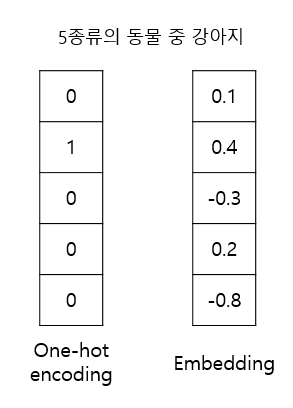

In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Embedding(n_words,   # 어휘 사전의 크기 : 102,967
                           200,       # 출력차원 / 200차원의 벡터로 단어를 임베딩 / 102,967 x 200
                           embeddings_regularizer = "l2"))

model.summary()     # (None, None, 200)  # 배치 차원, 타임 스테, 임베딩 차원
                    # 전체 모델 파라키터의 개수 : 102,967 x 200 = 20,593,400개

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         20593400  
Total params: 20,593,400
Trainable params: 20,593,400
Non-trainable params: 0
_________________________________________________________________


### **3. RNN Model 만들기 with LSTM**

In [ ]:
model.add(layers.LSTM(16))    # hidden output acivation default = "tanh"
                              # hidden recurrent_activation default = "hard_sigmoid"

model.add(layers.Flatten())                    
model.add(layers.Dense(1, activation = "sigmoid"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         20593400  
_________________________________________________________________
lstm (LSTM)                  (None, 16)                13888     
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 20,607,305
Trainable params: 20,607,305
Non-trainable params: 0
_________________________________________________________________


### **4. 감성 분석 RNN Model Training**

#### **1) Model compile**

In [ ]:
model.compile(loss = "binary_crossentropy",
              optimizer = "adam", metrics = ["acc"])

#### **2) Model parameter save by checkpoint**

In [ ]:
import time
from tensorflow.keras.callbacks import  ModelCheckpoint, TensorBoard

callback_list = [ModelCheckpoint(filepath = "sentiment_run_checkpoint.h5",
                                 monitor = "val_loss",
                                 save_best_only = True),
                 TensorBoard(log_dir = "sentiment_run_logs/{}".format(time.asctime()))]

#### **3) Model Training**

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size = 64, epochs = 10,
                    validation_split = 0.3, 
                    callbacks = callback_list)

Epoch 1/10
411/411 [==============================] - 125s 298ms/step - loss: 24.1903 - acc: 0.6340 - val_loss: 0.7469 - val_acc: 0.7899
Epoch 2/10
411/411 [==============================] - 121s 294ms/step - loss: 0.6310 - acc: 0.8175 - val_loss: 0.5756 - val_acc: 0.8499
Epoch 3/10
411/411 [==============================] - 119s 289ms/step - loss: 0.5586 - acc: 0.8562 - val_loss: 0.5469 - val_acc: 0.8604
Epoch 4/10
411/411 [==============================] - 117s 285ms/step - loss: 0.5137 - acc: 0.8708 - val_loss: 0.5301 - val_acc: 0.8590
Epoch 5/10
411/411 [==============================] - 115s 280ms/step - loss: 0.4724 - acc: 0.8807 - val_loss: 0.4714 - val_acc: 0.8706
Epoch 6/10
411/411 [==============================] - 114s 278ms/step - loss: 0.4552 - acc: 0.8887 - val_loss: 0.4961 - val_acc: 0.8727
Epoch 7/10
411/411 [==============================] - 114s 278ms/step - loss: 0.4397 - acc: 0.8933 - val_loss: 0.4880 - val_acc: 0.8689
Epoch 8/10
411/411 [===========================

#### **4) Loss and Accuracy graph**

<function matplotlib.pyplot.show>

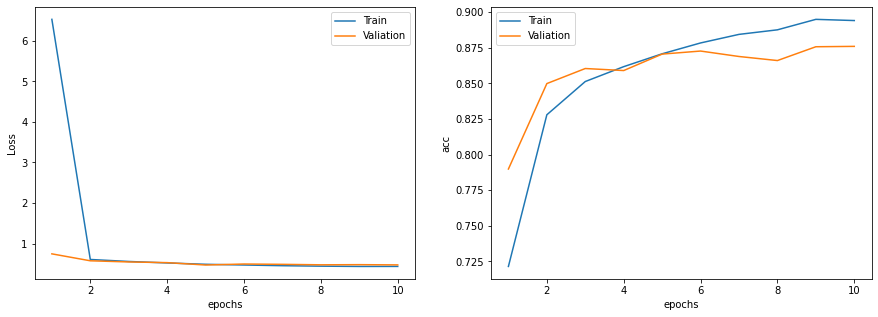

In [ ]:
### Loss
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
epochs = np.arange(1, 11)
plt.plot(epochs, history.history["loss"], label = "Train")
plt.plot(epochs, history.history["val_loss"], label = "Valiation")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

### Accuracy
plt.subplot(1, 2, 2)
epochs = np.arange(1, 11)
plt.plot(epochs, history.history["acc"], label = "Train")
plt.plot(epochs, history.history["val_acc"], label = "Valiation")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.show

### **5. 감성 분석 RNN Model Evaluation**

#### **1) chekcpoint 복원**

In [ ]:
model.load_weights("sentiment_run_checkpoint.h5")

#### **2) Model Evalutaion**

In [ ]:
model.evaluate(X_test, y_test)

391/391 [==============================] - 18s 46ms/step - loss: 0.4765 - acc: 0.8714


[0.4764980375766754, 0.8714399933815002]

#### **3) Prediction**

In [ ]:
# 10개 샘플, 확률로 출력

print(model.predict_proba(X_test[:10]))

# 10개 샘플, 클래스로 출력
print(model.predict_classes(X_test[:10]))

[[0.01018283]
 [0.01159874]
 [0.00332832]
 [0.9654529 ]
 [0.922603  ]
 [0.8697282 ]
 [0.01430205]
 [0.89075565]
 [0.00986159]
 [0.90414846]]
[[0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## **두 번째 프로젝트 : 텐서플로로 글자 단위 언어 모델 구현**

### **1. Data Preparation**

#### **1) Data 읽어오기**
The Tragedy if Hamlet  - William Shakespeare


In [ ]:
# !wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch16/pg2265.txt

In [ ]:
import numpy as np

### 텍스트를 읽고 처리합니다.

with open("/content/drive/MyDrive/data/pg2265.txt", "r", encoding = "utf-8") as f :
  text = f.read()

text = text[15858 :]
print("Text data : ", text[:100])

Text data :  The Tragedie of Hamlet

Actus Primus. Scoena Prima.

Enter Barnardo and Francisco two Centinels.

  


#### **2) 텍스트를 정수 값으로 인코딩**

In [ ]:
chars = set(text)
print("모든 철자, 기호:", chars)

char2int = {ch : i for i, ch in enumerate(chars)}     # 글자를 정수로 매핑
print("각 철자, 기호에 번호 부여 : ", char2int)

int2char = dict(enumerate(chars))                     # 정수를 글자로 매핑
print("dictionary type {번호 : 글자} : ", int2char)

text_ints = np.array([char2int[ch] for ch in text], dtype = np.int32)
print("Text의 글을 단어로 표현 : ", text_ints)

len(text) , len(chars)

모든 철자, 기호: {'(', 'n', '&', 'o', 'Y', 'L', 'x', ' ', ';', 'j', 'c', 'D', '\n', ',', 'G', 'N', 'I', 'z', '.', 'Z', 'E', 'H', 'T', 'K', 't', 'Q', 'S', 'C', 'u', "'", '-', 'k', '[', ']', 'W', 'V', 'i', '?', 'l', 'r', 'p', 'g', 'm', 'f', 'a', 'B', 'A', 'v', 'q', '!', 'b', 'R', '1', ':', 'e', 'F', 'P', 'O', 's', 'w', 'd', 'h', ')', 'y', 'M'}
각 철자, 기호에 번호 부여 :  {'(': 0, 'n': 1, '&': 2, 'o': 3, 'Y': 4, 'L': 5, 'x': 6, ' ': 7, ';': 8, 'j': 9, 'c': 10, 'D': 11, '\n': 12, ',': 13, 'G': 14, 'N': 15, 'I': 16, 'z': 17, '.': 18, 'Z': 19, 'E': 20, 'H': 21, 'T': 22, 'K': 23, 't': 24, 'Q': 25, 'S': 26, 'C': 27, 'u': 28, "'": 29, '-': 30, 'k': 31, '[': 32, ']': 33, 'W': 34, 'V': 35, 'i': 36, '?': 37, 'l': 38, 'r': 39, 'p': 40, 'g': 41, 'm': 42, 'f': 43, 'a': 44, 'B': 45, 'A': 46, 'v': 47, 'q': 48, '!': 49, 'b': 50, 'R': 51, '1': 52, ':': 53, 'e': 54, 'F': 55, 'P': 56, 'O': 57, 's': 58, 'w': 59, 'd': 60, 'h': 61, ')': 62, 'y': 63, 'M': 64}
dictionary type {번호 : 글자} :  {0: '(', 1: 'n', 2: '&', 3: 'o', 4: '

(162849, 65)

#### **3) Data를 Sequence data x와 y 생성**

In [ ]:
def reshape_data(sequence, batch_size, num_steps) :

  mini_batch_length = batch_size * num_steps              # 배치 하나의 길이 (배치 크기 x 시퀀스 길이)
  num_batchs = int(len(sequence) / mini_batch_length)     # 생성될 배치의 개수
  
  if num_batchs * mini_batch_length + 1 > len(sequence) : # 전체 배치의 글자수가 data의 글자수보다 많으면, 배치 하나를 줄여라.
  
    num_batchs = num_batchs - 1

  # print(len(sequence), mini_batch_length, num_batchs, (mini_batch_length*num_batchs))

  # 전체 배치에 포함되지 않는 시퀀스 끝부분은 삭제합니다.   - 배치로 생성되는 데이터만 남기기.
  x = sequence[0 : num_batchs * mini_batch_length]            
  y = sequence[1 : num_batchs * mini_batch_length + 1]      # x를 이용해 y를 예측하기에 y가 한 단어 뒤의 값을 갖는다.
  # print(x,len(x), y, len(y))

  # x와 y를 시퀀스 배치의 리스트로 나눕니다.
  x_bacth_splits = np.split(x, batch_size)        # x와 y를 배치 크기로 등분을 한다. 
  y_bacth_splits = np.split(y, batch_size)        # ex) 1280개의 단어를 64(배치크기)로 나눈다.                    
                                                  # 한 묶음에 20개씩 
  # print(len(y_bacth_splits), len(y_bacth_splits[1]), len(y_bacth_splits[-1]))

  # 합쳐진 배치 크기는 bacth_size x mini_batch_length가 됩니다.
  x = np.stack(x_bacth_splits)      
  y = np.stack(y_bacth_splits)

  return x, y


### 테스트 - 시퀀스 길이를 10으로 가정, 배치크기 64

train_x, train_y = reshape_data(text_ints, 64, 10)
print("Train_x Size : ", train_x.shape) 
print("Train_x 10개 : ", train_x[0, : 10])
print("Train_y 10개 : ", train_y[0, : 10])
print("Train_x 10개 문자화: ", "".join(int2char[i] for i in train_x[0, : 10]))
print("Train_y 10개 문자화: ", "".join(int2char[i] for i in train_y[0, : 10]))


Train_x Size :  (64, 2540)
Train_x 10개 :  [22 61 54  7 22 39 44 41 54 60]
Train_y 10개 :  [61 54  7 22 39 44 41 54 60 36]
Train_x 10개 문자화:  The Traged
Train_y 10개 문자화:  he Tragedi


#### **4) Mini batch 생성**

In [ ]:
def create_batch_generator(data_x, data_y, num_steps) :                         # Generator : 대용량 반복 수행 시, 메모리를 더욱 효율적으로 사용하기 위한 도구

  batch_size, tot_batch_length = data_x.shape[0:2] 

  num_batches = int(tot_batch_length / num_steps)   # 전체 미니 배치 개수

  for b in range(num_batches) :   # 미니 배치 순서대로

    yield (data_x[ : , b*num_steps : (b+1)*num_steps],                           # yield : 원하는 값을 리턴하며, 실행 흐름을 일시 정지하여 함수를 재활용할 수 있는 상태로 만든다.
           data_y[ : , b*num_steps : (b+1)*num_steps])
   
bgen = create_batch_generator(train_x[:, :100], train_y[:, :100], 15)

for x, y in bgen :
  print(x.shape, y.shape, end = "")
  print("".join(int2char[i] for i in x[0, : ]).replace("\n", "*"), '    ',
        "".join(int2char[i] for i in y[0, : ]).replace("\n", "*"))


(64, 15) (64, 15)The Tragedie of      he Tragedie of 
(64, 15) (64, 15) Hamlet**Actus       Hamlet**Actus P
(64, 15) (64, 15)Primus. Scoena       rimus. Scoena P
(64, 15) (64, 15)Prima.**Enter B      rima.**Enter Ba
(64, 15) (64, 15)arnardo and Fra      rnardo and Fran
(64, 15) (64, 15)ncisco two Cent      cisco two Centi


In [ ]:
batch_size = 64
num_steps = 100

train_x, train_y = reshape_data(text_ints, batch_size, num_steps)

print(train_x.shape, train_y.shape)

(64, 2500) (64, 2500)


#### **5) One-hot encoding**

글자 단위 RNN model은 처리하는 글자마다 그래디언트를 모두 계산하여 사용.

이러기 위해서 타깃 데이터도 전체 타임 스텝에 걸쳐 원-핫 인코딩을 해야한다.

(위 방법엣는 일련의 시퀀스(리뷰 텍스트)를 처리한 후 손실함수로부터 그래디언트를 계산)

In [ ]:
from tensorflow.keras.utils import to_categorical

train_encoded_x = to_categorical(train_x)
train_encoded_y = to_categorical(train_y)

print(train_encoded_x.shape, train_encoded_y.shape)

print(np.max(train_x), np.max(train_y))   # 원-핫인코딩 길이 = max + 1

(64, 2500, 65) (64, 2500, 65)
64 64


### **2. 글자 단위 RNN Model 만들기**

#### **1) 먼저, Sequential class 객체 생성**

In [ ]:
from tensorflow.keras import models, layers

char_model = models.Sequential()

#### **2) LSTM 바로 추가 instead of Embedding due to One-hot encoding**

\
- 고려사항

\
1. 모델 훈련 시 길이가 100인 시퀀스 주입 (즉, 타임 스텝 길이 = 100)
  
  - 하지만 새로운 글자를 생성 시, 이전 글자를 주입하여 한 글자씩 생성 (즉, 샘플링 시 배치크기 = 1)
  - 훈련과 샘플링 모드에서 사용하는 시퀀스 길이가 다르다.
  
    -  = "시간에 따라 동적으로 펼친다"

    - 텐서플로의 Keras API를 사용하면 가변 길이 시퀀스를 다루는 작업도 간단히 처리 가능

    - LSTM층에서 가변 길이 시퀀스를 처리하려면 타입 스텝 길이에 해당하는 input_shape의 첫 번째 차원을 None으로 지정.

    - 두 번째 차원은 원-핫 인코딩 벡터의 크기가 된다.

\
2. 모든 타입 스텝에 대해 그래디언트를 계싼하여 모델을 업데이트 한다.
  
  - 따라서 LSTM층이 시퀀스의 마지막 타임 스텝의 출력만 반환하지 않고 전체 시퀀스에 대해 출력을 만들어야한다.
  
  - 이렇게 하려면 LSTM층의 return_sequences = True로 지정
  


In [ ]:
### 128개의 순환 유닛을 가진 LSTM 층을 모델에 추가.

num_classes = len(chars)  # 텍스트에 있는 모든 글자 수

char_model.add(layers.LSTM(128, input_shape = (None, num_classes),
                          return_sequences = True))





#### **3) Dense 층 without Flatten**


\
- 기존에는 Dense층 이전에 Flatten층을 생성

- 이 예제는 모든 타임 스텝에 대한 손실을 계산해야 하므로 LSTM층에서 출력되는 3차원 텐서를 그대로 두어야 한다.

- LSTM층에서 출력되는 텐서 크기 (배치 개수, 타임 스텝 개수, 순환 유닛 개수)

  - Dense 층 통과 시 이 텐서의 첫 번째와 두 번째 차원이 유지되야 한다.

  - 이 작업을 위해 Flatten층을 추가하지 않고 LSTM 층의 출력을 타임 스텝 순으로 Dense층에 주입하고, 
  \
  결과를 받아 다시 타임 스텝 순서대로 쌓아야한다.

In [ ]:
char_model.add(layers.TimeDistributed(layers.Dense(num_classes,
                                                  activation = "softmax")))

#### **4) Model Summary**

\
Model Parmater

\
- LSTM 층

 $ W_{xf} $ = (128, 65) dimension

 $ W_{hf} $ = (128, 128) dimension  and 절편 = 128개
 
 따라서, 삭제 게이트에 필요한 Model Parameter 개수 : (128x65)+(128+128+128) = 24,832개

 LSTM에는 이런 가중치가 네벌 더 있으므로 Total Mpdel Parameter = 99,328개

\
- TimeDistributed 층
  
  Model Parameter를 갖지 않는다.

  summary에서 출력한 값은 Dense층의 Model Parameter 개수

  Dense층의 입력 차원 = 128,  65개의 유닛이 있으므로 절편을 고려한

  Total Model Parameter : 65 x 128 + 65 = 8,386개

In [ ]:
char_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         99328     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 65)          8385      
Total params: 107,713
Trainable params: 107,713
Non-trainable params: 0
_________________________________________________________________


### **3. 글자 단위 RNN Model Training**

#### **1) Gradient clipping 사용**

- Gradient Exploding을 피하기 위한 대표적인 방법

\
1. clipnorm 
 - L2 노름의 임계값 지정

 - L2 노름 > clipnorm인 경우, 클리핑된 그래디언트 = 그래디언트 * clipnorm / Gradient의 L2 노름 

\
2. clipvalue
  - 절대값으로 임계값을 지정
  - -clipvalue 보다 작은 gradient = - clipvalue
    
     +clipvalue 보다 큰 gradient = + clipvalue

\
　　　$\rightarrow$ 　두 방식을 동시에 사용 가능

In [ ]:
from tensorflow.keras.optimizers import Adam

adam = Adam(clipnorm = 5.0)   

#### **2) categorical_crossentropy**

- 65개의 글자에 대한 확률을 출력하는 다중 클래스 모델이다.

In [ ]:
char_model.compile(loss = "categorical_crossentropy", optimizer = adam)

#### **3) Checkpoint callback 준비**

In [ ]:
from tensorflow.keras.callbacks import  ModelCheckpoint

callback_list = [ModelCheckpoint(filepath = "char_rnn_checkpoint.h5")]

#### **4) 500번 Epochs동안 모델 훈련**

In [ ]:
for i in range(500) :
  bgen = create_batch_generator(train_encoded_x,
                                train_encoded_y,
                                num_steps)
  
  char_model.fit_generator(bgen, steps_per_epoch = 25, epochs = 1,
                           callbacks = callback_list, verbose = 0)    # verbose = 0 : 훈련과정을 출력하지 않는다.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


### **4. 글자 단위 RNN Model로 텍스트 생성**

텍스트를 만들기 위해 앞서 설명한 것처럼 배치크기 1, 타임 스텝 길이 1을 만들어 모델에 주입한다.

#### **1) get_top_char 함수 정의**

　　: 모델에서 출력된 65개의 확률 값에서 하나를 랜덤하게 선택할 함

In [ ]:
np.random.seed(42)

def get_top_char(probas, char_size, top_n = 5) :
  p = np.squeeze(probas)
  p[np.argsort(p)[ : -top_n]] = 0.0
  p = p / np.sum(p)
  ch_id = np.random.choice(char_size, 1, p = p)[0]
  return ch_id

#### **2) "The"란 초기 문자열로 이어지는 텍스트 생성**

In [ ]:
seed_text = "The"

for ch in seed_text:
  num = [char2int[ch]]
  onehot = to_categorical(num, num_classes = 65)
  onehot = np.expand_dims(onehot, axis = 0)
  probas = char_model.predict(onehot)

num = get_top_char(probas, len(chars))
seed_text += int2char[num]

#### **3) 500번 반복**
\
- 예측한 문자열을 비슷한 과정으로 인코딩하여 다시 모델에 주입 

- 반환된 클래스 확률값을 사용하여 다시 다음 글자를 선택

\
　
  $\rightarrow$ 이런 과정을 for반복문을 사용하여 500번 되풀이하여 긴 텍스트 생성

In [ ]:
for i in range(500) :
  onehot = to_categorical([num], num_classes = 65)
  onehot = np.expand_dims(onehot, axis = 0)
  probas = char_model.predict(onehot)
  num = get_top_char(probas, len(chars))
  seed_text += int2char[num]

print(seed_text)

The we, toriende t illie it ane, m. wer thingowie mandess w to ind il ande therengorino ierd the,


 tone me is t therer wiss t iss mino wile we mucour th tes ar a mator touene m.
 w indyoue, tord, iessue thenou tsth angereringr wis athind th wes thishe is tshe, me merert ares mererd inenge m. a ter m. mares is inowert t mer we, ings tonde te t ier ie wanou me, mathish tonou is anourere thes is we ar wis windo we,

 ierer m. is t atondore thithesur at w m. toneris is wndorthous me mas iss mucke, wer
